# Mandatory Challenge
## Context
You work in the data analysis team of a very important company. On Monday, the company shares some good news with you: you just got hired by a major retail company! So, let's get prepared for a huge amount of work!

Then you get to work with your team and define the following tasks to perform:   
1. You need to start your analysis using data from the past.  
2. You need to define a process that takes your daily data as an input and integrates it.  

You are in charge of the second part, so you are provided with a sample file that you will have to read daily. To complete you task, you need the following aggregates:
* One aggregate per store that adds up the rest of the values.
* One aggregate per item that adds up the rest of the values.

You can import the dataset `retail_sales` from Ironhack's database. 

## Your task
Therefore, your process will consist of the following steps:
1. Read the sample file that a daily process will save in your folder. 
2. Clean up the data.
3. Create the aggregates.
4. Write three tables in your local database: 
    - A table for the cleaned data.
    - A table for the aggregate per store.
    - A table for the aggregate per item.

## Instructions
* Read the csv you can find in Ironhack's database.
* Clean the data and create the aggregates as you consider.
* Create the tables in your local database.
* Populate them with your process.

In [1]:
# your code here
import pandas as pd
from sqlalchemy import create_engine

In [2]:
driver = 'mysql+pymysql:'
user = 'ironhacker_read'
password = 'ir0nhack3r'
ip = '35.239.232.23'
database = 'retail_sales'
connection_string = f'{driver}//{user}:{password}@{ip}/{database}'
engine = create_engine(connection_string)
query = """
        SELECT * FROM raw_sales
"""

df = pd.read_sql(query, engine)
df

,date,shop_id,item_id,item_price,item_cnt_day
0,2015-01-04,29,1469,1199.0,1.0
1,2015-01-04,28,21364,479.0,1.0
2,2015-01-04,28,21365,999.0,2.0
3,2015-01-04,28,22104,249.0,2.0
4,2015-01-04,28,22091,179.0,1.0
5,2015-01-04,28,21842,149.0,1.0
6,2015-01-04,28,21881,299.0,1.0
7,2015-01-04,29,6930,2199.0,1.0
8,2015-01-04,29,10515,169.0,1.0
9,2015-01-04,29,8624,149.0,1.0


In [3]:
df.describe()

,shop_id,item_id,item_price,item_cnt_day
count,4545.000000,4545.000000,4545.000000,4545.000000
mean,34.021122,11140.459406,1031.686121,1.103630
std,16.565517,6558.649572,2073.919990,0.536967
min,2.000000,30.000000,3.000000,-1.000000
25%,22.000000,4977.000000,249.000000,1.000000
50%,31.000000,11247.000000,479.000000,1.000000
75%,50.000000,16671.000000,1192.000000,1.000000
max,59.000000,22162.000000,27990.000000,10.000000


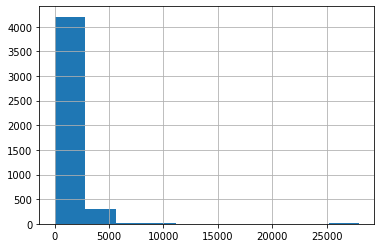

In [13]:
df["item_price"].hist()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4545 entries, 0 to 4544
Data columns (total 5 columns):
date            4545 non-null datetime64[ns]
shop_id         4545 non-null int64
item_id         4545 non-null int64
item_price      4545 non-null float64
item_cnt_day    4545 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 177.6 KB


In [6]:
#per saber els Nan que hi ha a la taula
df.isna().sum()

date            0
shop_id         0
item_id         0
item_price      0
item_cnt_day    0
dtype: int64

In [7]:
df_new = df.sort_values(["item_price"],ascending=False)

In [9]:
df_new = df_new[df_new["item_price"] < 15000]

In [10]:
df_new = df_new.sort_values(["item_price"],ascending=True)

In [11]:
df_new = df_new[df_new["item_price"] > 100]

In [12]:
#I decided to discard the lines above the 15000 and the lines below 100 because under my point of view they were not useful
df_new

,date,shop_id,item_id,item_price,item_cnt_day
1697,2015-01-04,31,22088,119.0,2.0
1698,2015-01-04,31,22087,119.0,1.0
190,2015-01-04,34,22087,119.0,1.0
189,2015-01-04,34,22088,119.0,1.0
1704,2015-01-04,34,22088,119.0,1.0
1332,2015-01-04,5,22088,119.0,1.0
4257,2015-01-04,6,22088,119.0,1.0
4362,2015-01-04,5,22088,119.0,1.0
1013,2015-01-04,35,22088,119.0,2.0
183,2015-01-04,31,22087,119.0,1.0


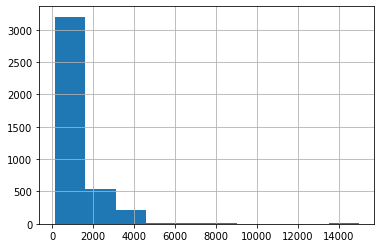

In [14]:
df_new["item_price"].hist()

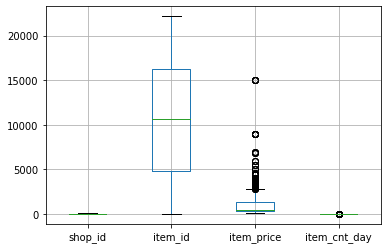

In [15]:
df_new.boxplot()